In [1]:
import os 
import pickle 
from natsort import natsorted

def load_data_as_dict(directory_path):
    """
    Return pickle file in directory_path as a list. 
    Also returns a list of all the unique id's in the dataset. 
    Why do we need unique id? 
        Lets say a task is randomly mapped 100 times. 
        All the 100 data (dict in pickle file) will have the same id. 
        So it is easier to retrieve all the mapping for a single task
    """
    entries = os.listdir(directory_path)
    files = natsorted([entry for entry in entries if os.path.isfile(os.path.join(directory_path, entry))])

    list_of_dicts = []
    list_of_uuids = []

    for file_name in files:
        file_path = os.path.join(directory_path, file_name)

        with open(file_path, 'rb') as file:
            data_dict = pickle.load(file)
            list_of_dicts.append(data_dict)

            uuid = data_dict['task_dag'].id

            if uuid not in list_of_uuids:
                list_of_uuids.append(uuid)

    return list_of_dicts, list_of_uuids

In [2]:
single_mapping_data, _ = load_data_as_dict('data/task_7')
print(f"Size of Dataset {len(single_mapping_data)}")

Size of Dataset 72807


In [3]:
from networkx.algorithms.isomorphism import GraphMatcher

"""
Two graphs which contain the same number of 
graph vertices connected in the same way 
are said to be isomorphic. 
"""
def isomorphic(graph1, graph2):
    GM = GraphMatcher(graph1, graph2)
    return GM.is_isomorphic()

def group_by_isomorphism(data):
    """
    Check if two graphs in data is isomorphic, 
    if they are, put them into the same list. 

    Returns 
        1. isomorphic_groups contains the list of all similar graphs. (not usefule for us)
        2. list_of_same_graphs (self explanatory)
    """
    isomorphic_groups = []
    list_of_same_graphs = []

    for item in data:
        graph = item['task_dag'].graph
        added_to_group = False
        
        # Iterate through existing isomorphic groups
        for existing_group, existing_data_group in zip(isomorphic_groups, list_of_same_graphs):
            if isomorphic(graph, existing_group[0]):
                existing_group.append(graph)
                existing_data_group.append(item)
                added_to_group = True
                break

        if not added_to_group:
            # If no isomorphic group found, create a new one
            isomorphic_groups.append([graph])
            list_of_same_graphs.append([item])

    return isomorphic_groups, list_of_same_graphs

_, list_of_same_graphs = group_by_isomorphism(single_mapping_data)


"""
list_of_same_graphs.
Each unique graph is a list with all its occurences
"""
print("Number of Unique Tasks", len(list_of_same_graphs))

Number of Unique Tasks 638


Number of similar graphs for each unique task: [670, 278, 181, 7, 956, 704, 1389, 457, 24658, 89, 228, 597, 59, 268, 154, 162, 774, 245, 17, 30, 60, 244, 118, 257, 468, 246, 106, 143, 637, 407, 248, 46, 335, 134, 133, 722, 180, 183, 436, 345, 268, 542, 193, 56, 116, 508, 441, 253, 47, 107, 336, 221, 100, 30, 123, 38, 560, 683, 415, 45, 29, 285, 271, 698, 246, 66, 455, 618, 551, 148, 121, 166, 234, 42, 177, 319, 117, 113, 91, 79, 74, 36, 90, 183, 263, 21, 25, 171, 787, 280, 65, 143, 133, 5, 171, 43, 137, 202, 15, 545, 43, 181, 164, 14, 311, 305, 64, 557, 147, 801, 157, 1, 858, 128, 67, 308, 56, 180, 33, 124, 53, 186, 423, 262, 172, 270, 189, 191, 90, 164, 133, 319, 385, 37, 266, 504, 179, 8, 53, 418, 145, 148, 36, 15, 10, 192, 120, 279, 383, 166, 12, 134, 104, 227, 2, 70, 71, 15, 52, 599, 29, 226, 44, 3, 123, 154, 1, 43, 160, 156, 27, 29, 69, 179, 209, 186, 37, 186, 262, 9, 190, 2, 148, 8, 71, 122, 173, 93, 32, 75, 143, 47, 13, 5, 142, 167, 7, 25, 127, 2, 131, 29, 125, 191, 43, 39, 6, 1

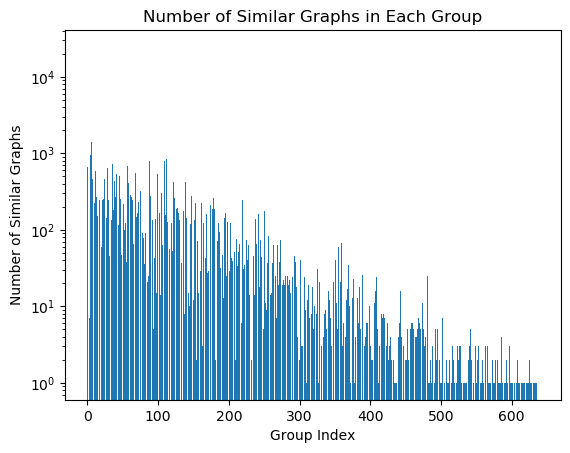

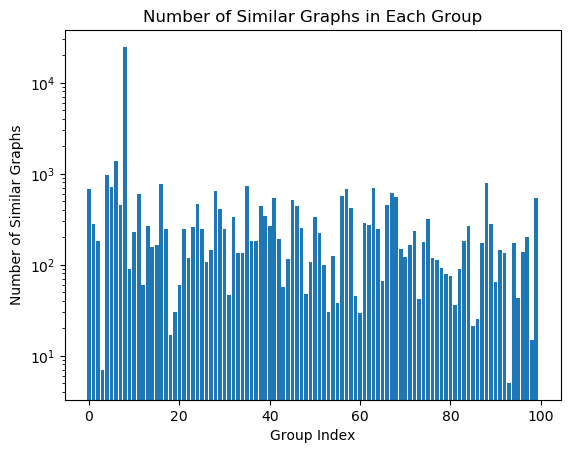

In [4]:
num_similar_graph = [len(group) for group in list_of_same_graphs] 
print("Number of similar graphs for each unique task:", num_similar_graph)

import matplotlib.pyplot as plt
plt.bar(range(len(num_similar_graph)), num_similar_graph)
plt.yscale('log')
plt.xlabel('Group Index')
plt.ylabel('Number of Similar Graphs')
plt.title('Number of Similar Graphs in Each Group')
plt.show()

num_similar_graph = num_similar_graph[0:100]
plt.bar(range(len(num_similar_graph)), num_similar_graph)
plt.yscale('log')
plt.xlabel('Group Index')
plt.ylabel('Number of Similar Graphs')
plt.title('Number of Similar Graphs in Each Group')
plt.show()

Index of the group with the maximum occurrences: 8


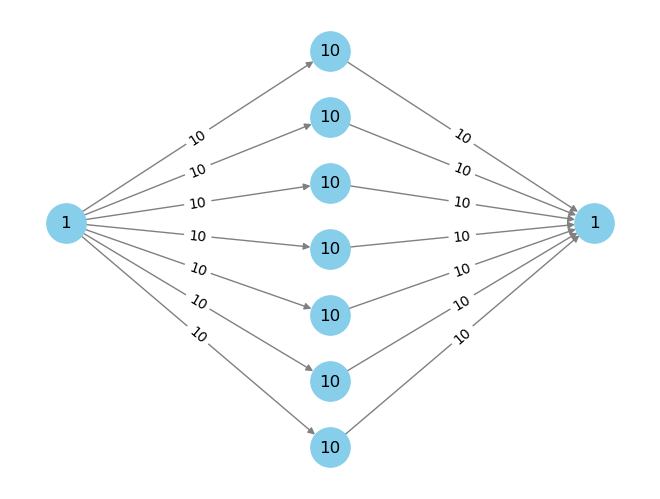

Min: 2665.0, Max: 3613.0
25th Percentile 2676.0
75th Percentile 2962.0


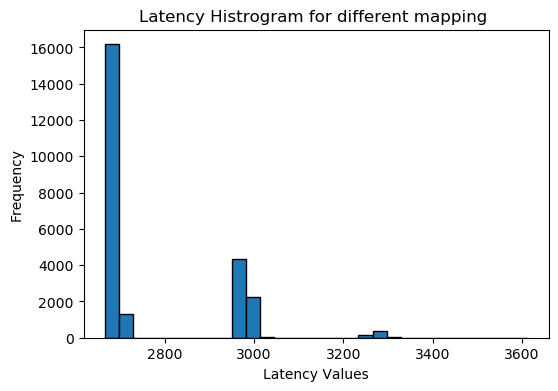

In [5]:
max_occurrences_index = num_similar_graph.index(max(num_similar_graph))
print("Index of the group with the maximum occurrences:", max_occurrences_index)

most_freq_graph_list = list_of_same_graphs[max_occurrences_index]
most_freq_graph_list[0]['task_dag'].plot()

import numpy as np

def plot_latency_histogram(graph_list, fig_width=6, fig_height=4):
    latency_list = []

    for task in graph_list:
        latency = task['network_processing_time']
        latency_list.append(float(latency))

    print(f"Min: {np.min(latency_list)}, Max: {np.max(latency_list)}")
    print(f"25th Percentile {np.percentile(latency_list, 25)}")
    print(f"75th Percentile {np.percentile(latency_list, 75)}")

    plt.figure(figsize=(fig_width, fig_height))
    plt.hist(latency_list, bins=30, edgecolor='black')
    plt.title('Latency Histrogram for different mapping ')
    plt.xlabel('Latency Values')
    plt.ylabel('Frequency')
    plt.show()

plot_latency_histogram(most_freq_graph_list)


In [9]:
"""
Creating Training Dataset 
    Make sure, each graph is not occuring more than 1000 time. 
"""

training_dataset = []
for graph_list in list_of_same_graphs:
    for idx, data in enumerate(graph_list):
        if (idx+1) == 1000: break
        training_dataset.append(data)

print(f"Final Size of Training Dataset is {len(training_dataset)}")
print(type(training_dataset[0]))

os.makedirs('data/training_data')

# Specify the file name
file_name = 'data.pkl'

# Combine the folder path and file name
file_path = os.path.join(folder_path, file_name)

# Open the file in binary write mode and serialize the list of dictionaries
with open(file_path, 'wb') as file:
    pickle.dump(list_of_dicts, file)

print(f'The list of dictionaries has been saved to {file_path}')

Final Size of Training Dataset is 48758
<class 'dict'>
